In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as SP

from math import sqrt
from scipy import stats
from scipy.optimize import minimize

import GPy

# Problem 1 (40 pts)

Many learning problems can be formulated as optimization problems which aim at optimization of target function $f(\theta)$. Typically, each evaluation of $f(\theta)$ is computationally **very expensive**. 

What **Bayesian optimization** approach does: 

 * Find such $\theta^*$ that $f(\theta^*)$ is maximal. 
 * And at the same time, **reduce** the number of evaluations $f(\theta)$.

**We want to find the maximum of a function $f(x)$**.<br> 

Let us consider a function $f(x) = (1- \tanh x^2)\sin(4x)$.

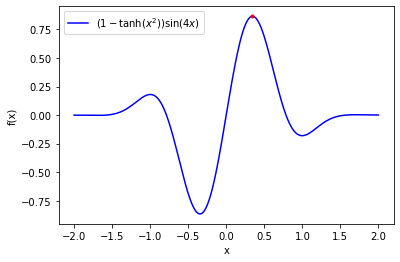

In [2]:
def f(x):
    return (1-np.tanh(x**2)) * np.sin(4*x)


X_test = np.linspace(-2, 2, 400)
plt.plot(X_test, f(X_test), 'b', label=r"$(1- \tanh(x^2))\sin(4x)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc='best')
x_teor_max = .345044
y_teor_max = f(x_teor_max)
plt.plot(x_teor_max, y_teor_max, 'r.')
plt.show()

You have only $N$ noisy outputs of the function $f(x)$ and you need to know at which point you should sample next in order to find maximum of $f(x)$.

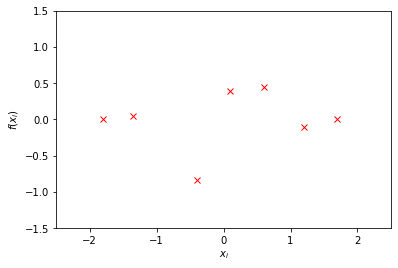

In [3]:
X_train = np.array([-1.8, -1.35, -0.4, 0.1, 0.6, 1.2, 1.7])
Y_train = f(X_train) + 0.01 * np.random.randn()
plt.plot(X_train, Y_train, 'rx')
plt.xlabel("$x_i$")
plt.ylabel("$f(x_i)$")
plt.axis([-2.5, 2.5, -1.5, 1.5])
plt.show()

**Again, the main question here is where to sample next?**

Let us fit a GPR model to our data. This gives a posteriors distribution of functions that can generate this data.

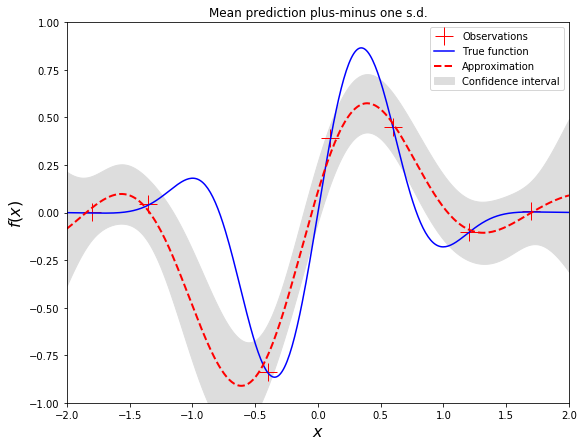

In [4]:
def kernel(x, y, l):
    return np.exp(-.5*((x[:, None] - y)/l)**2)


l = .6
sigma = .03

L = np.linalg.cholesky(kernel(X_train, X_train, l) + sigma * np.eye(len(X_train)))

# compute the mean at our test points.
B = np.linalg.solve(L, kernel(X_train, X_test, l))
mu = B.T @ np.linalg.solve(L, Y_train)

# compute the variance at our test points.
s = np.sqrt(np.diag(kernel(X_test, X_test, l)) - np.sum(B**2, axis=0))

def plotResults_1(mu, s, X_test):
    plt.figure(figsize=(9, 7))
    plt.plot(X_train, Y_train, 'r+', ms=18, label="Observations")
    plt.plot(X_test, f(X_test), 'b-', label="True function")
    plt.gca().fill_between(
        X_test, mu - s, mu + s, color="#dddddd", label="Confidence interval")
    plt.plot(X_test, mu, 'r--', lw=2, label="Approximation")
    plt.title(r'Mean prediction plus-minus one s.d.')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.axis([-2, 2, -1, 1])
    plt.legend()
    plt.show()

plotResults_1(mu, s, X_test)

This plot represents prediction of the mean of $f(x)$ and corresponding confidence interval.

**According to this plot, is it a good idea to sample in the point at the maximum of mean prediction?<be>
Or better to sample in the point where the uncertainty is maximal?**
    
Answering to these questions defines the exploration-exploitation trade-off.

### Utility (acquisition) functions
Actually, acquisition function answers to the question above.

In the Lecture 6 three different acquisition functions were mentioned:

* Probability of improvement,
* Expected improvement,  
    $EI(x) = \mathbb E_{p(\tilde f)}\max (0, \tilde f(x) - f_\max)$
* GP-UCB (Upper Confidence Bound),  
    $UCB(x) = \tilde m(x) + \beta\hat\sigma(x)$

### Bayesian Optimization

Finally, we are approaching task formulations.

Bayesian optimization algorithm iteratively selects points where the function should be evaluated:

* Fitting a GP model.
* Defining an acquisition function.
* Find a maximum of acquisition function by using a numerical optimization algorithm.

### Tasks:
- **(30 pts)** Implement any **two** acquisition functions and using them find the maximum of $f(x), x\in[-2,2]$

---
***The derivation of EI for 1D case***

$f \sim \mathcal N(m, k) \quad\rightarrow\quad f = m + \sigma\epsilon, \quad \sigma = \sqrt{k(x, x)}, \;\epsilon \sim \mathcal N(0, 1)$ 

$$
    EI(x) = \int_{f_\max}^{\infty} (f - f_\max)\mathcal N(f|m, \sigma^2)df\\
    = (m - f_\max)\int_{f_\max}^\infty \mathcal N(f|m, \sigma^2)df
    + \sigma\int_{f_\max}^\infty \!\!\epsilon\;\frac{1}{\sigma} \mathcal N(\epsilon|0, 1)\sigma d\epsilon\\
    = (m - f_\max)\left(1-\Phi\left(\frac{f_\max - m}{\sigma}\right)\right)
    + \sigma\int_{\frac{f_\max - m}{\sigma}}^\infty \mathcal N(\epsilon|0, 1)d\left(\frac{\epsilon^2}{2}\right)
$$

Last term:
$$
   -\frac{\sigma}{\sqrt{2\pi}} \exp\left(-\frac{\epsilon^2}{2}\right)\;\bigg\vert_{\frac{f_\max-m}{\sigma}}^{\;\infty} = \sigma\phi\left(\frac{f_\max-m}{\sigma}\right)
$$

Ultimately
$$
    EI(x) = \big(m(x) - f_\max\big)\left(\!1-\Phi\left(\frac{f_\max-m(x)}{\sigma(x)}\right)\!\!\right) + \sigma(x)\,\phi\!\left(\frac{f_\max-m(x)}{\sigma(x)}\right)
$$

In [5]:
def probability_of_improvement(x):
    # your code here
    """ Returns the probability of improvement at query point x. """
    
    return probability_of_improvement(x)


def EI(M, S, f_max):
    out = (M-f_max) * (1-stats.norm.cdf((f_max-M)/S)) 
    out += S * stats.norm.pdf((f_max-M)/S)
    return out 


def UCB(M, S, beta=.3):
    return M + beta * S

In [6]:
a, b = -2., 2.

def GPR(M, n_iters, l=.6, sigma=.03, util_func='EI'):
    np.random.seed(1)

    X_test = np.linspace(a, b, M)
    sq_S0 = np.diag(kernel(X_test, X_test, l))

    def fit(X):
        Y = f(X) + sigma * np.random.randn(len(X))
        L = np.linalg.cholesky(kernel(X,X,l) + sigma*np.eye(len(X)))
        B = np.linalg.solve(L, kernel(X,X_test,l))
        S = np.sqrt(sq_S0 - np.sum(B**2, axis=0))
        M = np.dot(B.T, np.linalg.solve(L, Y))
        
        return Y, M, S
    
    def acquisition():
        if util_func == 'EI':
            return EI(M, S, f_max)
        return UCB(M, S)

    X = np.random.uniform(a, b, 1)
    f_max = f(X)
    history = {}
    history['x'] = [X[0]]
    history['f'] = [f_max[0]]
    for _ in range(n_iters):
        Y, M, S = fit(X)
        A = acquisition()
        x_max = X_test[A.argmax()]
        f_max = f(x_max)
        history['x'] += [x_max]
        history['f'] += [f_max]
        X = np.r_[X, x_max] 
        
    history['x'] = np.array(history['x'])
    history['f'] = np.array(history['f'])
    print('x_max', x_max,'\tf_max', f_max)
    return history, (M, S, X_test)

***The maximum of the $f(x) = (1- \tanh x^2)\sin(4x)$***

In [7]:
hist_UCB, args_UCB = GPR(70, 30, .3, util_func='UCB')
hist_EI, args_EI = GPR(70, 30, .3, util_func='EI')

x_max 0.318840579710145 	f_max 0.8597545069347289
x_max 0.318840579710145 	f_max 0.8597545069347289


---
- **(10 pts)** Plot all the results and explain which acquisition function is better and why. 

---

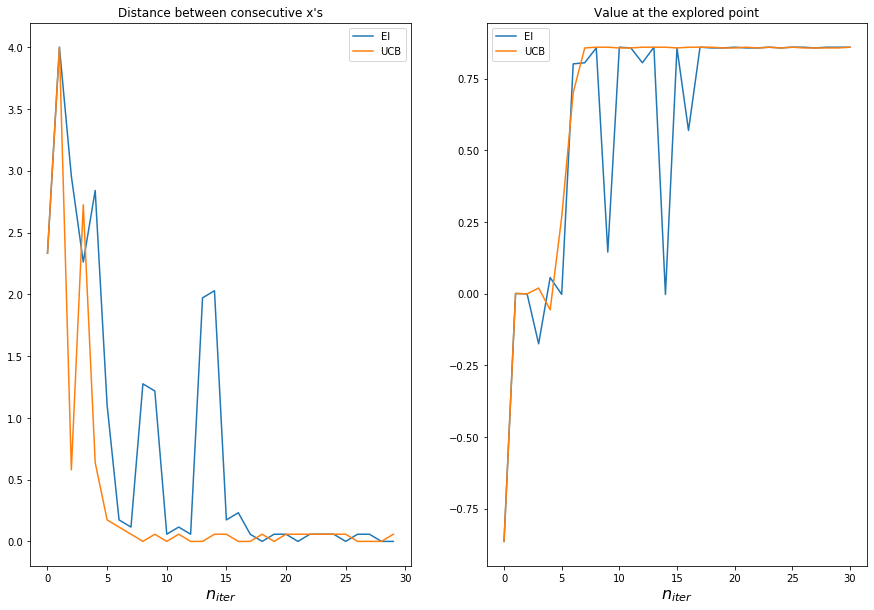

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax2.plot(hist_EI['f'], label='EI')
ax2.plot(hist_UCB['f'], label='UCB')
ax2.set_title("Value at the explored point")
ax2.set_xlabel('$n_{iter}$', size=16)
ax2.legend()

ax1.plot(np.abs(np.diff(hist_EI['x'])), label='EI')
ax1.plot(np.abs(np.diff(hist_UCB['x'])), label='UCB')
ax1.set_title("Distance between consecutive x's")
ax1.set_xlabel('$n_{iter}$', size=16)
ax1.legend();

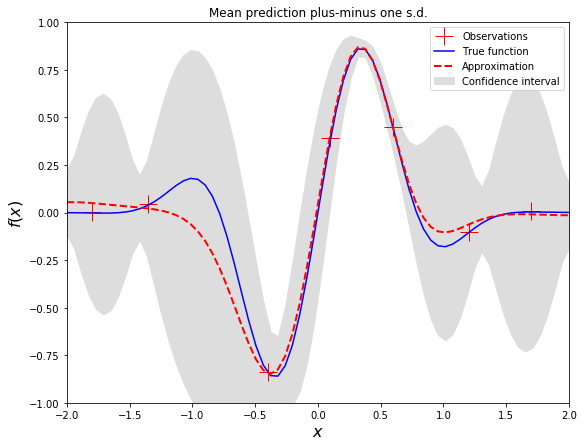

In [9]:
plotResults_1(*args_UCB)

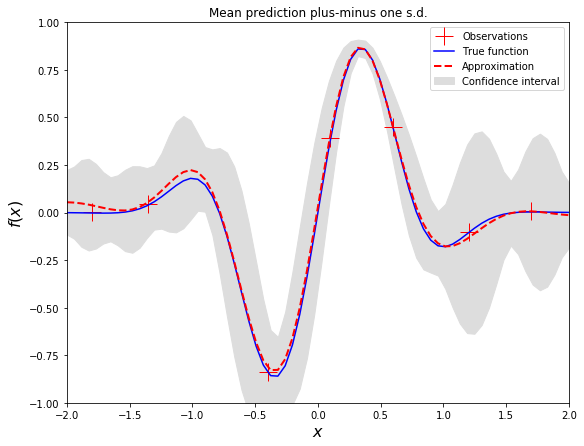

In [10]:
plotResults_1(*args_EI)

***As one can see from the last 4 plots, UCB finds faster the 'global' maximum (than EI), since it selects points with high variance less often. Though UCB performes better in finding maximum in the current task, it has less garantee that the real maximum has been missed unlike EI(judging only by the last 2 plots). And I have not implemented EI with the hyperparameter that can be tuned. So, the situation could be different in this case***

# Problem 2 (40 pts)

### Covariance Function Parameter Estimation
As we have seen in the Lecture 6, the parameters of the kernel can be estimated by maximizing the log-likelihood of the observations.

Let us consider a function $f(x) = 0.5\cos(2x)+\sin(0.9x)$.

You have $N$ noisy outputs of the function $f(x)$: $y_i = f(x_i) + \mathcal{N}(0,0.1), i = \{1,\ldots,N\}$ and you need to build a Gaussian process model for the data using a squared exponential kernel with parameters $\ell$ and $\sigma$.

In [11]:
def calc_LML(X, y, l, sigma):
    K = kernel(X, X, l) + sigma**2 * np.eye(len(X))
    L = np.linalg.cholesky(K)
    c = np.linalg.solve(L, y)
    det_L = np.multiply.reduce(np.diag(L))
    return - math.log(det_L) - .5 * c @ c

Log marginalcal likelihood: 6.081592519634631


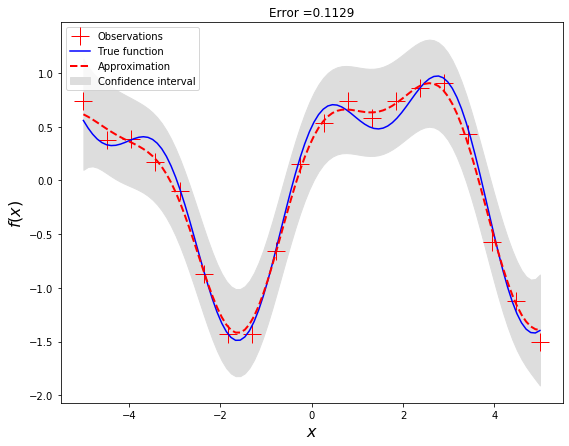

In [12]:
def f(x):
    return 0.5 * np.cos(2 * x) + np.sin(0.9 * x)

def plotResults_2(l, sigma, n_pts=20):
    # GP model is here
    np.random.seed(3)

    X_train = np.linspace(-5, 5, n_pts)
    X_test = np.linspace(-5, 5, 100)

    Y_train = f(X_train) + .1 * np.random.randn(len(X_train))

    L = np.linalg.cholesky(kernel(X_train, X_train, l) + sigma**2 * np.eye(len(X_train)))

    # compute the mean at our test points.
    B = np.linalg.solve(L, kernel(X_train, X_test, l))
    mu = B.T @ np.linalg.solve(L, Y_train)

    # compute the variance at our test points.
    s = np.sqrt(np.diag(kernel(X_test, X_test, l)) - (B**2).sum(0))

    print('Log marginalcal likelihood:', calc_LML(X_train, Y_train, l, sigma))
    plt.figure(figsize=(9, 7))
    plt.plot(X_train, Y_train, 'r+', ms=18, label="Observations")
    plt.plot(X_test, f(X_test), 'b-', label="True function")
    plt.gca().fill_between(
        X_test.flat, mu - 2*s, mu + 2*s, color="#dddddd", label="Confidence interval")
    plt.plot(X_test, mu, 'r--', lw=2, label="Approximation")
    plt.title(r'Mean prediction plus-minus one s.d.')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.title(
        'Error =' + str(round(np.linalg.norm(
            f(X_test) - mu, ord=np.inf) / np.linalg.norm(f(X_test), ord=np.inf), 4)))
    plt.legend()
    plt.show()

plotResults_2(1., .3)

**Your goal in this problem is to fit parameters $(\ell,\sigma)$ of the GP model by maximizing log-likelihood $L(\ell,\sigma) = \log{p(\mathbf{y}\mid\mathbf{x},\ell,\sigma)}$.**

* **(20 pts)** In the GP model defined above:
    * implement log-likelihood function $L(\ell,\sigma)$; 
    * plot the contour plot of the $L(\ell,\sigma)$ for two kernel parameters $(\ell,\sigma)$; 
    * using this plot, find an "optimal" values of $(\ell^*,\sigma^*)$ (where $L(\ell^*,\sigma^*)$ is maximal) and run the GP model with these parameters; 
    * plot the results and the value of log-likelihood, compute approximation error.  

---
Take $\mu(x)=0$
$$
    L = -\frac{1}{2}\log\det\left(\Sigma(\sigma, \ell)\right) - \frac{1}{2}y^\top \Sigma(\sigma, \ell)^{-1}y + \mathrm{const}
$$
Here $\Sigma(\sigma, \ell) = \exp\big(-\mathrm{pairwisedist}(X)\;/\;\ell\big) + \sigma^2 I$

**Implementation:**

$\Sigma = LL^\top$, since $L$ is lower-triangular, $\displaystyle det L = \prod_i L_{ii}$

$$
    \det K = \det(LL^\top) = \det L \cdot \det L = (\det L)^2
$$

First part:

$$
    - \frac{2}{2} \log\prod_i L{ii}\\
    - \text{math.log(np.multiply.reduce(np.diag($L$)))}
$$    

Second part:

$$
    -\frac{1}{2} c^\top c\\
    L^{-1}y = c \quad\rightarrow\quad Lc = y \quad\text{and}\quad c = \text{np.linalg.solve}(L, y)
$$

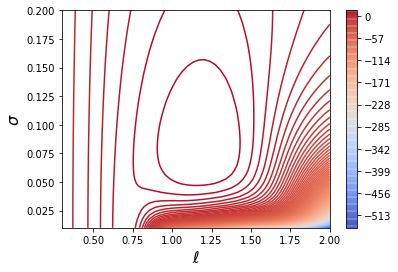

In [13]:
np.random.seed(3)
X = np.linspace(-5, 5, 20)
y = f(X) + .1 * np.random.randn(len(X))

n_disc = 50
LML = np.zeros((n_disc, n_disc))
Sx = np.linspace(1e-2, .2, n_disc)
Ly = np.linspace(.3, 2, n_disc)

for i, sq_s in enumerate(Sx):
    for j, l in enumerate(Ly):
#         K = sigma * kernel(X, X, l) + .01 * np.eye(len(X))
#         L = np.linalg.cholesky(K)
#         c = np.linalg.solve(L, y)
#         det_L = np.multiply.reduce(np.diag(L))
#         LML[i, j] -= math.log(det_L) + .5 * c @ c
        LML[i, j] = calc_LML(X, y, l, sq_s)

plt.contour(*np.meshgrid(Ly, Sx), LML, 200, cmap='coolwarm')
plt.xlabel('$\ell$', size=16)
plt.ylabel('$\sigma$', size=16)
plt.colorbar();

From the plot we can conclude that the maximum of the log marginal likelihood is near from $(\ell, \sigma) = (1.2, 0.1)$ (for 20 points discretization)

Log marginalcal likelihood: 14.417686528327597


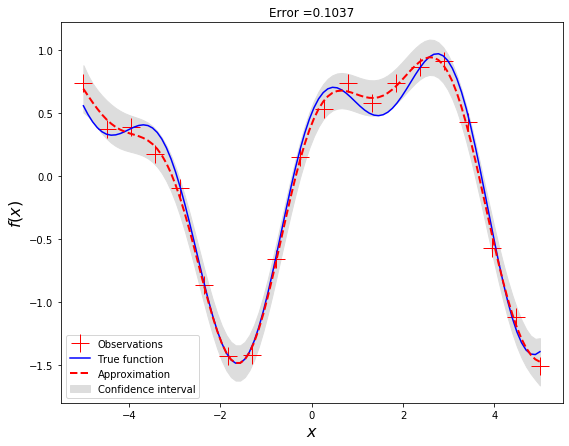

In [14]:
plotResults_2(1.2, .1, 20)

* **(10 pts)** Now, let's optimize $L(\ell,\sigma)$ with the use of numerical optimizers, say, ```scipy.optimize```:
    * set initial values of parameters $(\ell,\sigma) = 1.0, 1.5$ and find optimal $(\ell^*,\sigma^*)$ by optimization of $L(\ell,\sigma)$; 
    * plot the results, value of log-likelihood, compute approximation error.  
    
---

In [15]:
np.random.seed(3)
X = np.linspace(-5, 5, 20)
y = f(X) + np.random.normal(scale=.1, size=len(X))

objective = lambda t: -calc_LML(X, y, *t)

t0 = np.array([1., 1.5])
res_min = minimize(objective, t0, bounds=((.3, 2), (1e-2, .2)))

(l, sigma) = [1.2016221  0.07820828]
Log marginalcal likelihood: 14.860110710937192


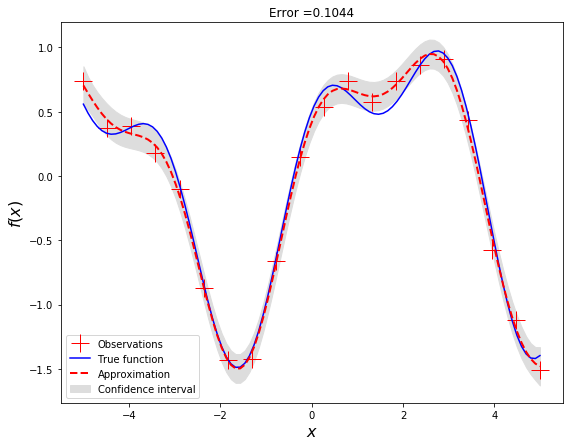

In [16]:
print('(l, sigma) =', res_min.x)
plotResults_2(*res_min.x)

* **(10 pts)** Again, maximize $L(\ell,\sigma)$ for the same GP model: 
    * this time initialize parameters $(\ell,\sigma) = 0.1, 0.1$. What has happened?
    * plot the results, value of log-likelihood, compute approximation error;
    * compare the results of all the three experiments and explain why they are similar/different.

In [17]:
np.random.seed(3)
X = np.linspace(-5, 5, 20)
y = f(X) + np.random.normal(scale=.1, size=len(X))

objective = lambda t: -calc_LML(X, y, *t)

t0 = np.array([.1, .1])
res_min = minimize(objective, t0, bounds=((.3, 2), (1e-2, .2)))

(l, sigma) = [1.20162208 0.07820823]
Log marginalcal likelihood: 14.860110710933172


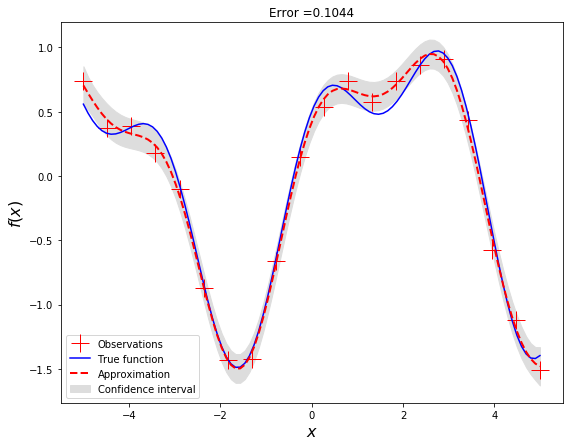

In [18]:
print('(l, sigma) =', res_min.x)
plotResults_2(*res_min.x)

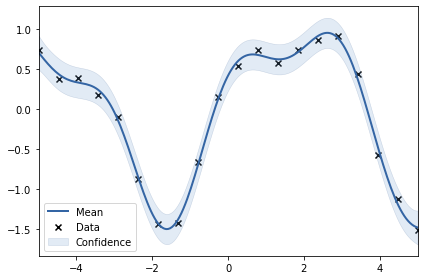

In [19]:
np.random.seed(3)
X = np.linspace(-5, 5, 20)
y = f(X) + np.random.normal(scale=.1, size=len(X))
k = GPy.kern.RBF(input_dim=1)

m = GPy.models.GPRegression(X[:, None], y[:, None], k)
m.kern.variance = 1.
m.Gaussian_noise = .1
m.kern.lengthscale = .1

m.optimize()
m.plot(plot_limits=((-5, 5)));

***Nothing has changed actually. The minimization procedure converges to the same optimimum. And the result we got in the lecture is due to the initialization seed. For example, if we seed is 4. We have this***

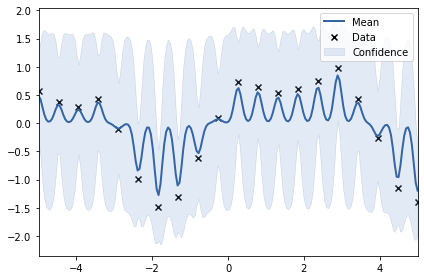

In [20]:
np.random.seed(4)
X = np.linspace(-5, 5, 20)
y = f(X) + np.random.normal(scale=.1, size=len(X))
k = GPy.kern.RBF(input_dim=1)

m = GPy.models.GPRegression(X[:, None], y[:, None], k)
m.kern.variance = 1.
m.Gaussian_noise = .1
m.kern.lengthscale = .1

m.optimize()
m.plot(plot_limits=((-5, 5)));

***But in other cases (I don't know how many there are such seeds when it converges to one loc. minimum and when to another, but) we have the same minimum that we get if we choose initial point (1. 1.5)***